In [1]:
import numpy as np
import pickle as pickle
from scipy import signal
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

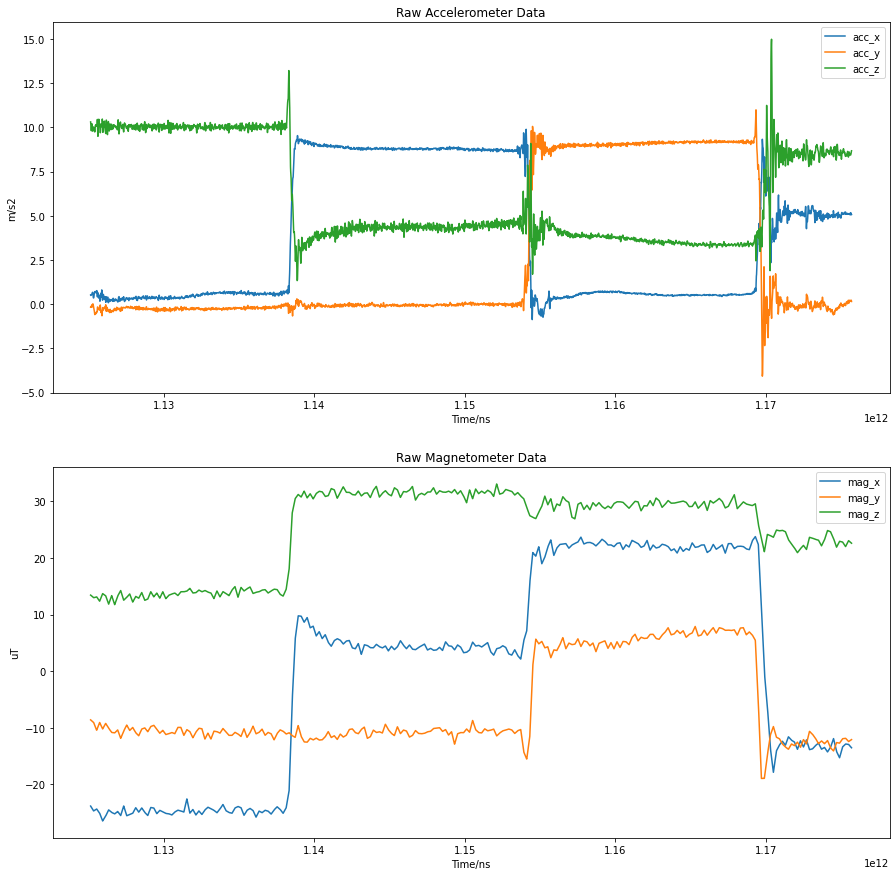

In [2]:
with open("./aggregated.pkl", "rb") as fid:
    data = pickle.load(fid)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))

# Retrieve ACC data.                                                                                                                                                    
ts_ACC = data['ACC'][:,0]  # Timestamps for ACC data.
acc_x = data['ACC'][:,1]
acc_y = data['ACC'][:,2]
acc_z = data['ACC'][:,3]

# Retrieve MAG data.
ts_MAG = data['MAG'][:,0]  # Timestamps for MAG data.
mag_x = data['MAG'][:,1]
mag_y = data['MAG'][:,2]
mag_z = data['MAG'][:,3]

# Orientation results.
ts_ORI = data['ORI'][:,0]  # Timestamps for ORIENTATION data.
pitch_ref = data['ORI'][:,1]
yaw_ref = data['ORI'][:,2]
roll_ref = data['ORI'][:,3]

# Plot ACC data.
ax1.plot(ts_ACC, acc_x)
ax1.plot(ts_ACC, acc_y)
ax1.plot(ts_ACC, acc_z)
ax1.set(xlabel='Time/ns', ylabel='m/s2', title='Raw Accelerometer Data')
ax1.legend(['acc_x', 'acc_y', 'acc_z'])

# Plot MAG data.
ax2.plot(ts_MAG, mag_x)
ax2.plot(ts_MAG, mag_y)
ax2.plot(ts_MAG, mag_z)
ax2.set(xlabel='Time/ns', ylabel='uT', title='Raw Magnetometer Data')
ax2.legend(['mag_x', 'mag_y', 'mag_z'])

# Question 2a

In [3]:
def normalize(a, b, c):
    """
    To normalize the values before appending R Matrix
    """
    return 1 / (np.sqrt(((a**2) + (b**2) + (c**2))))


def plotter(ax, x_values, y_values, xlabel, ylabel, title, color):
    """
    Plotting helper function
    """
    ax.plot(x_values, y_values, color=color)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)


def filter_signal(noisy_signal, sample_freq):
    """
    Takes in a noisy signal and sample frequency to filter noise away with bandstop filter
    The filter used in this function is a bandstop filter between 45Hz to 55Hz
    """
    N = 4
    cutOffHigh = 55.0/(sample_freq/2)
    cutOffLow = 45.0/(sample_freq/2)
    btype = 'bandstop'
    b, a = signal.butter(N, [cutOffLow, cutOffHigh], btype)

    # btype = 'low'
    # cutOff = 0.5 / (sample_freq/2)
    # b, a = signal.butter(N, cutOff, btype)
    
    return signal.filtfilt(b, a, noisy_signal)    
    

def getRotationMatrix(acc_x, acc_y, acc_z, mag_x, mag_y, mag_z):
    """
    Implement the method needed to get the rotation matrix
    """
    a = np.array(([acc_x], [acc_y], [acc_z]))
    m = np.array(([mag_x], [mag_y], [mag_z]))
    a_cross_m = np.cross(a, m, axis=0)
    a_cross_m_a = np.cross(a_cross_m, a, axis=0)

    col0 = normalize(a_cross_m_a[0], a_cross_m_a[1], a_cross_m_a[2]) * a_cross_m_a
    col1 = normalize(a_cross_m[0], a_cross_m[1], a_cross_m[2]) * a_cross_m
    col2 = normalize(a[0], a[1], a[2]) * a

    R = np.hstack((
        col0,
        col1,
        col2
    ))

    return R

    
def getOrientation(R):
    """
    Implement the method needed to obtain the pitch, roll, and yaw.
    """
    pitch = - np.arcsin(R[0][2])
    yaw = np.arctan2(R[1][2],R[2][2])
    roll = np.arctan2(R[0][1],R[0][0])

    return (pitch, yaw, roll)

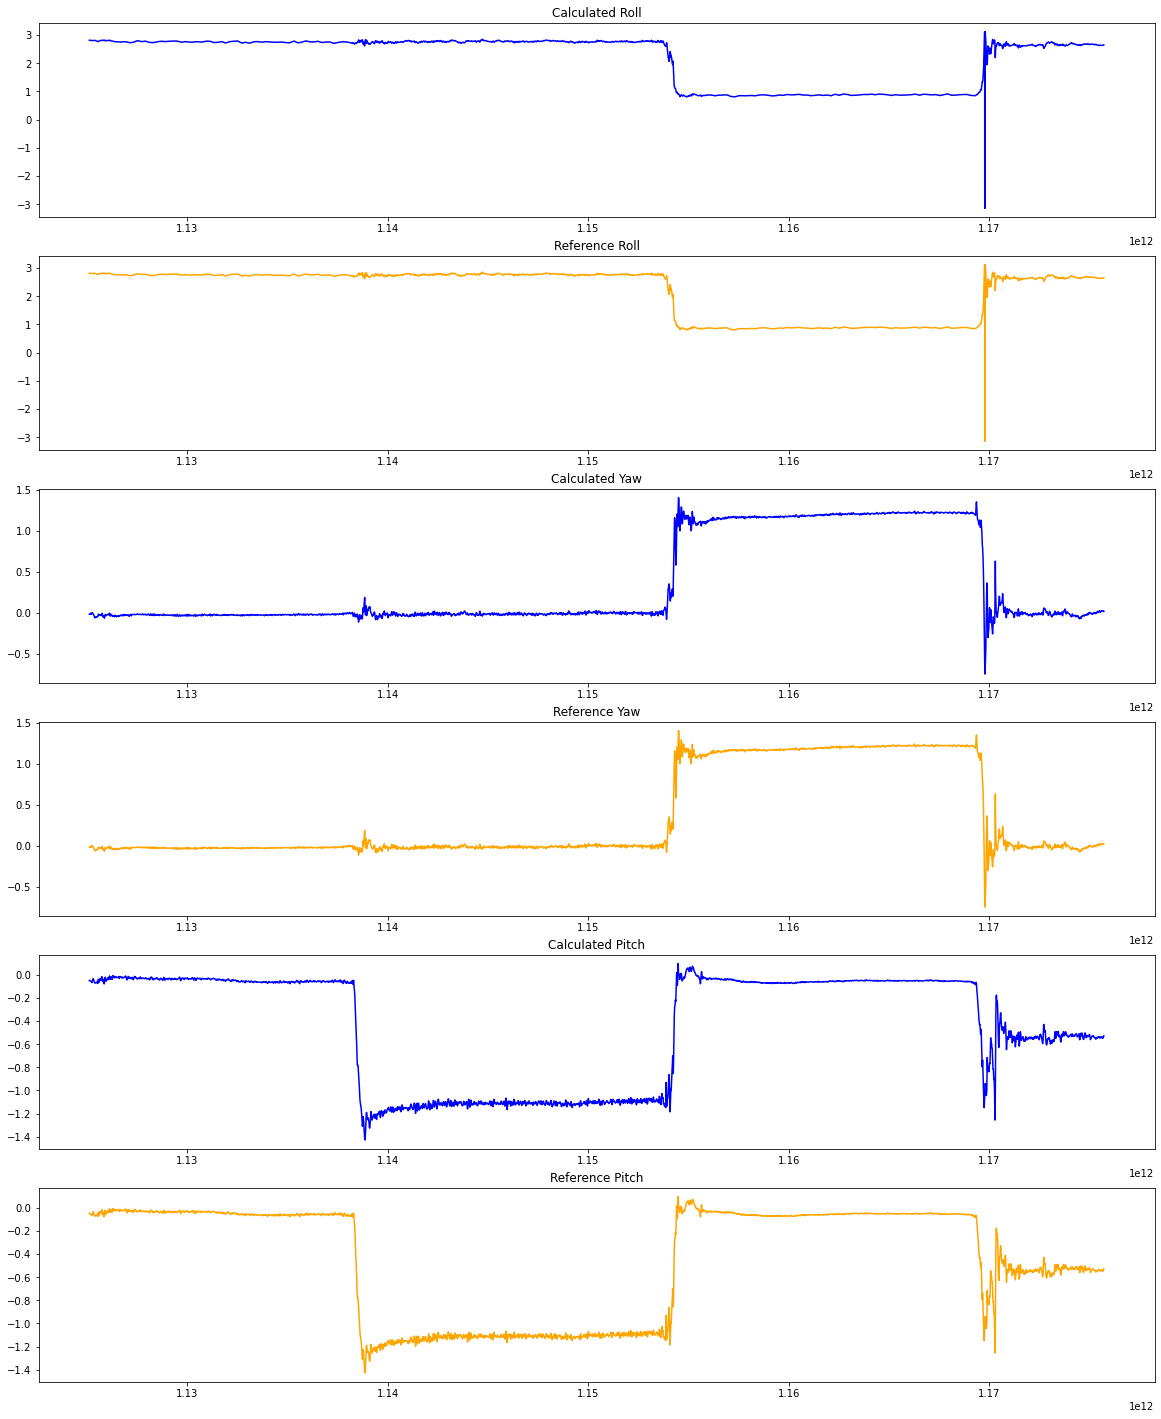

In [4]:
calculated_pitch = []
calculated_yaw = []
calculated_roll = []

for i in range(len(acc_x)):
    R = getRotationMatrix(acc_x[i], acc_y[i], acc_z[i], mag_x[i], mag_y[i], mag_z[i])
    (pitch, yaw, roll) = getOrientation(R)
    calculated_pitch.append(pitch)
    calculated_yaw.append(yaw)
    calculated_roll.append(roll)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(20,25))

plotter(ax1, ts_ORI, calculated_roll, '', '', 'Calculated Roll', 'b')
plotter(ax2, ts_ORI, roll_ref, '', '', 'Reference Roll', 'orange')

plotter(ax3, ts_ORI, calculated_yaw, '', '', 'Calculated Yaw', 'b')
plotter(ax4, ts_ORI, yaw_ref, '', '', 'Reference Yaw', 'orange')

plotter(ax5, ts_ORI, calculated_pitch, '', '', 'Calculated Pitch', 'b')
plotter(ax6, ts_ORI, pitch_ref, '', '', 'Reference Pitch', 'orange')


# Question 2b

Frequcies of interest/Hz: [[  0.        ]
 [ 49.98419056]
 [ 50.01053963]
 [199.98946037]
 [200.01580944]] 



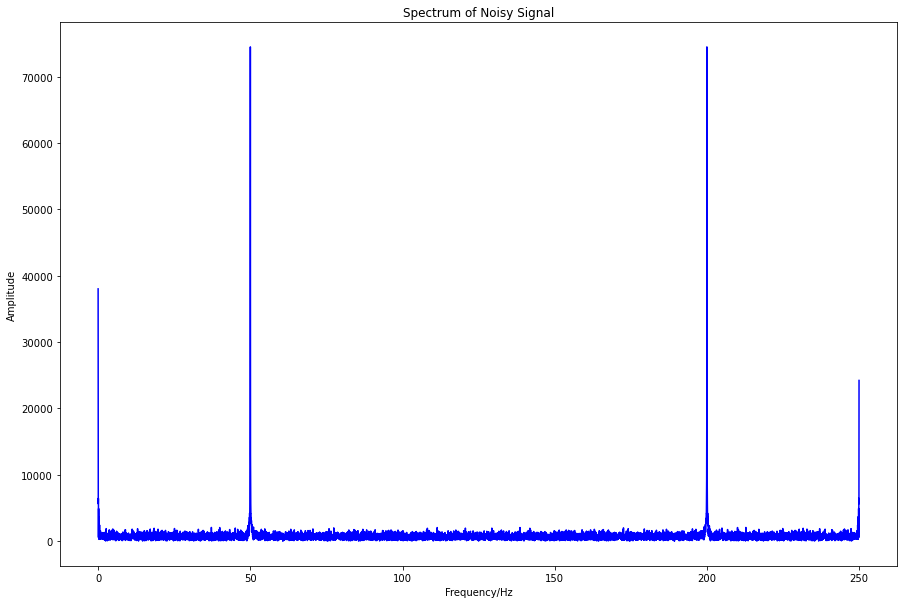

In [5]:
# Unpickle the file 'synthetic.pkl'
with open("synthetic.pkl", "rb") as fid:
    data = pickle.load(fid)

ts_noisy_acc = data['ACC'][:,0]    
noisy_acc_x = data['ACC'][:,1]
noisy_acc_y = data['ACC'][:,2]
noisy_acc_z = data['ACC'][:,3]
noisy_acc = [noisy_acc_x, noisy_acc_y, noisy_acc_z]


ts_noisy_mag = data['MAG'][:,0]  
noisy_mag_x = data['MAG'][:,1]
noisy_mag_y = data['MAG'][:,2]
noisy_mag_z = data['MAG'][:,3]
noisy_mag = [noisy_mag_x, noisy_mag_y, noisy_mag_z]


# Carry out an FFT analysis on the acc_x and plot the spectrum.
sample_freq = 250
frequency = np.arange(len(noisy_acc_x)) * (sample_freq/len(noisy_acc_x))
spectrum=np.abs(fft(noisy_acc_x))

fig, ax = plt.subplots(figsize=(15,10))
plotter(ax, frequency, spectrum, 'Frequency/Hz', 'Amplitude', 'Spectrum of Noisy Signal', 'b')


# Identity location of peaks
threshold= np.max(spectrum)/2.0
indices = np.argwhere( spectrum > threshold)
print('Frequcies of interest/Hz: %s \n' % frequency[indices])

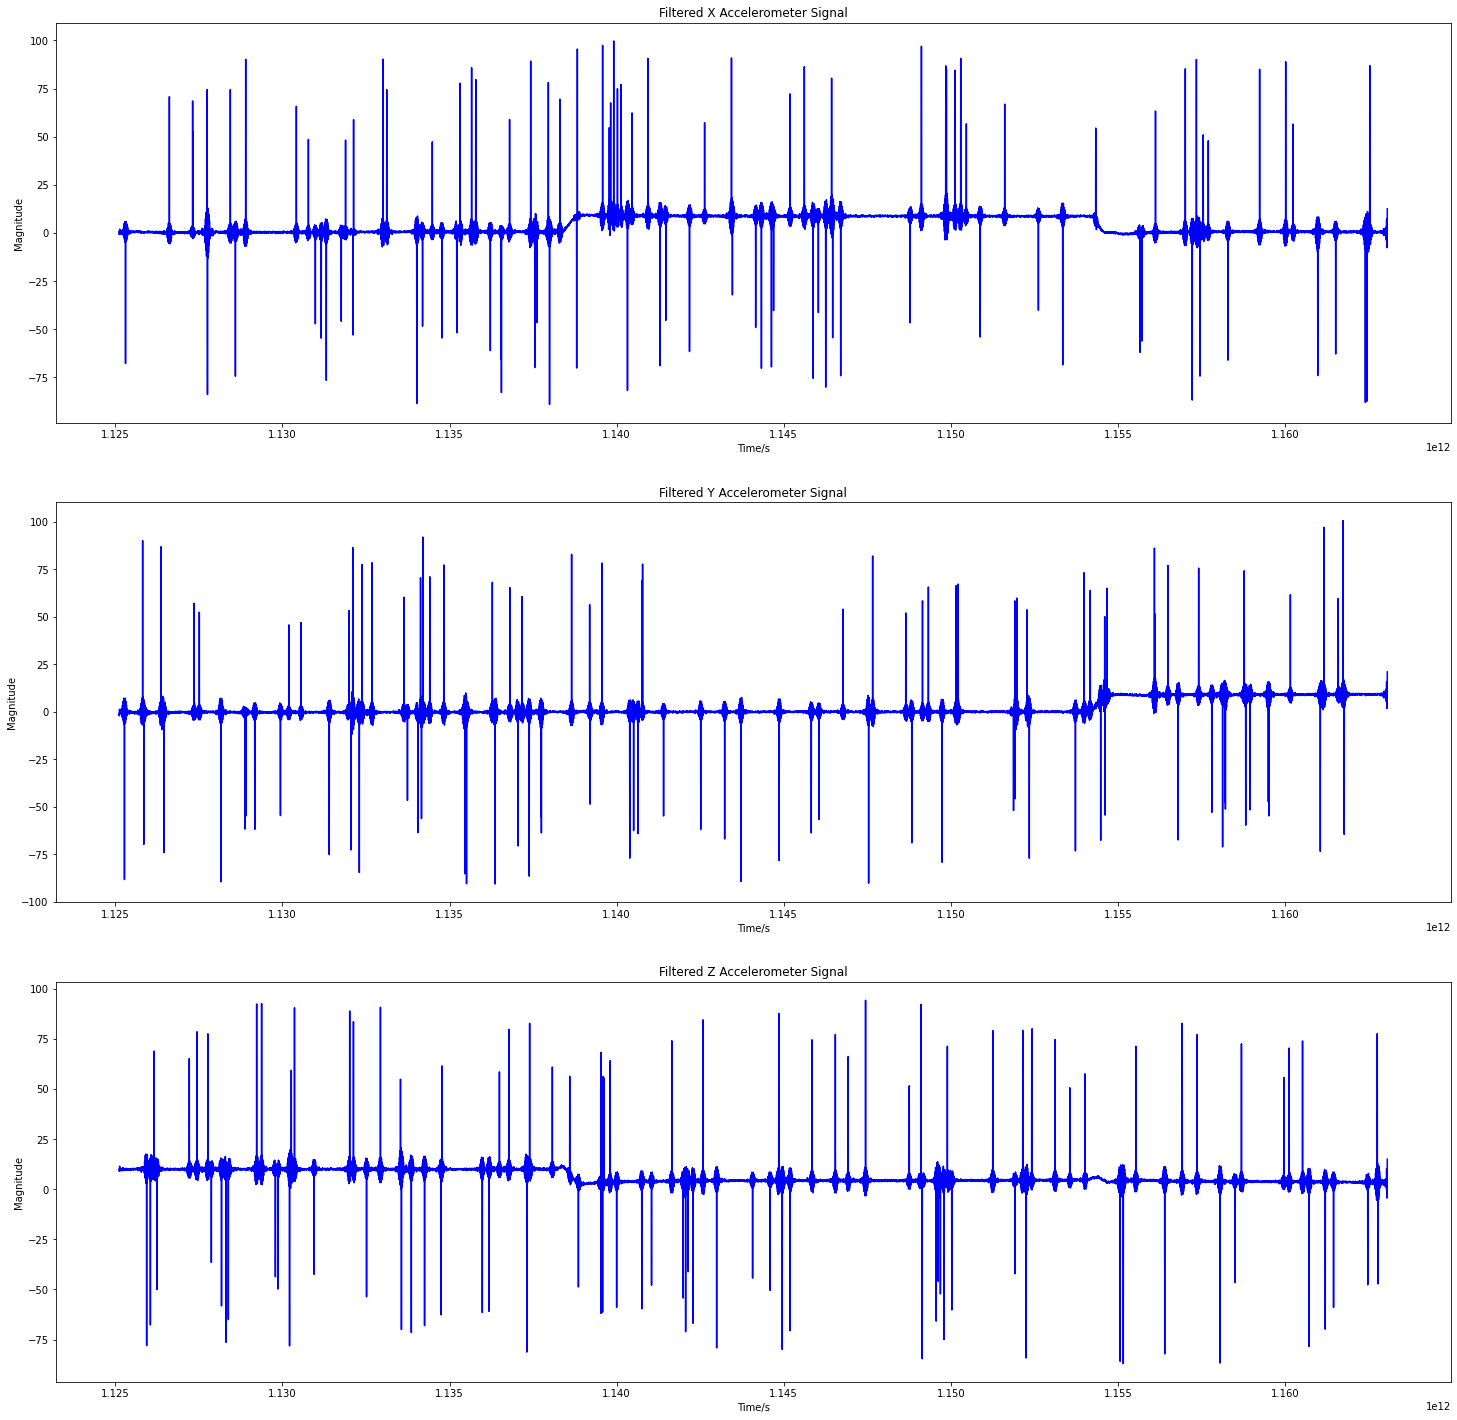

In [6]:
noise_filter_acc = []
noise_filter_mag = []

for n in noisy_acc:
  noise_filter_acc.append(filter_signal(n, sample_freq))

for n in noisy_mag:
  noise_filter_mag.append(filter_signal(n, sample_freq))
  
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25,25))
plotter(ax1, ts_noisy_acc, noise_filter_acc[0], 'Time/s', 'Magnitude', 'Filtered X Accelerometer Signal', color='b')
plotter(ax2, ts_noisy_acc, noise_filter_acc[1], 'Time/s', 'Magnitude', 'Filtered Y Accelerometer Signal', color='b')
plotter(ax3, ts_noisy_acc, noise_filter_acc[2], 'Time/s', 'Magnitude', 'Filtered Z Accelerometer Signal', color='b')

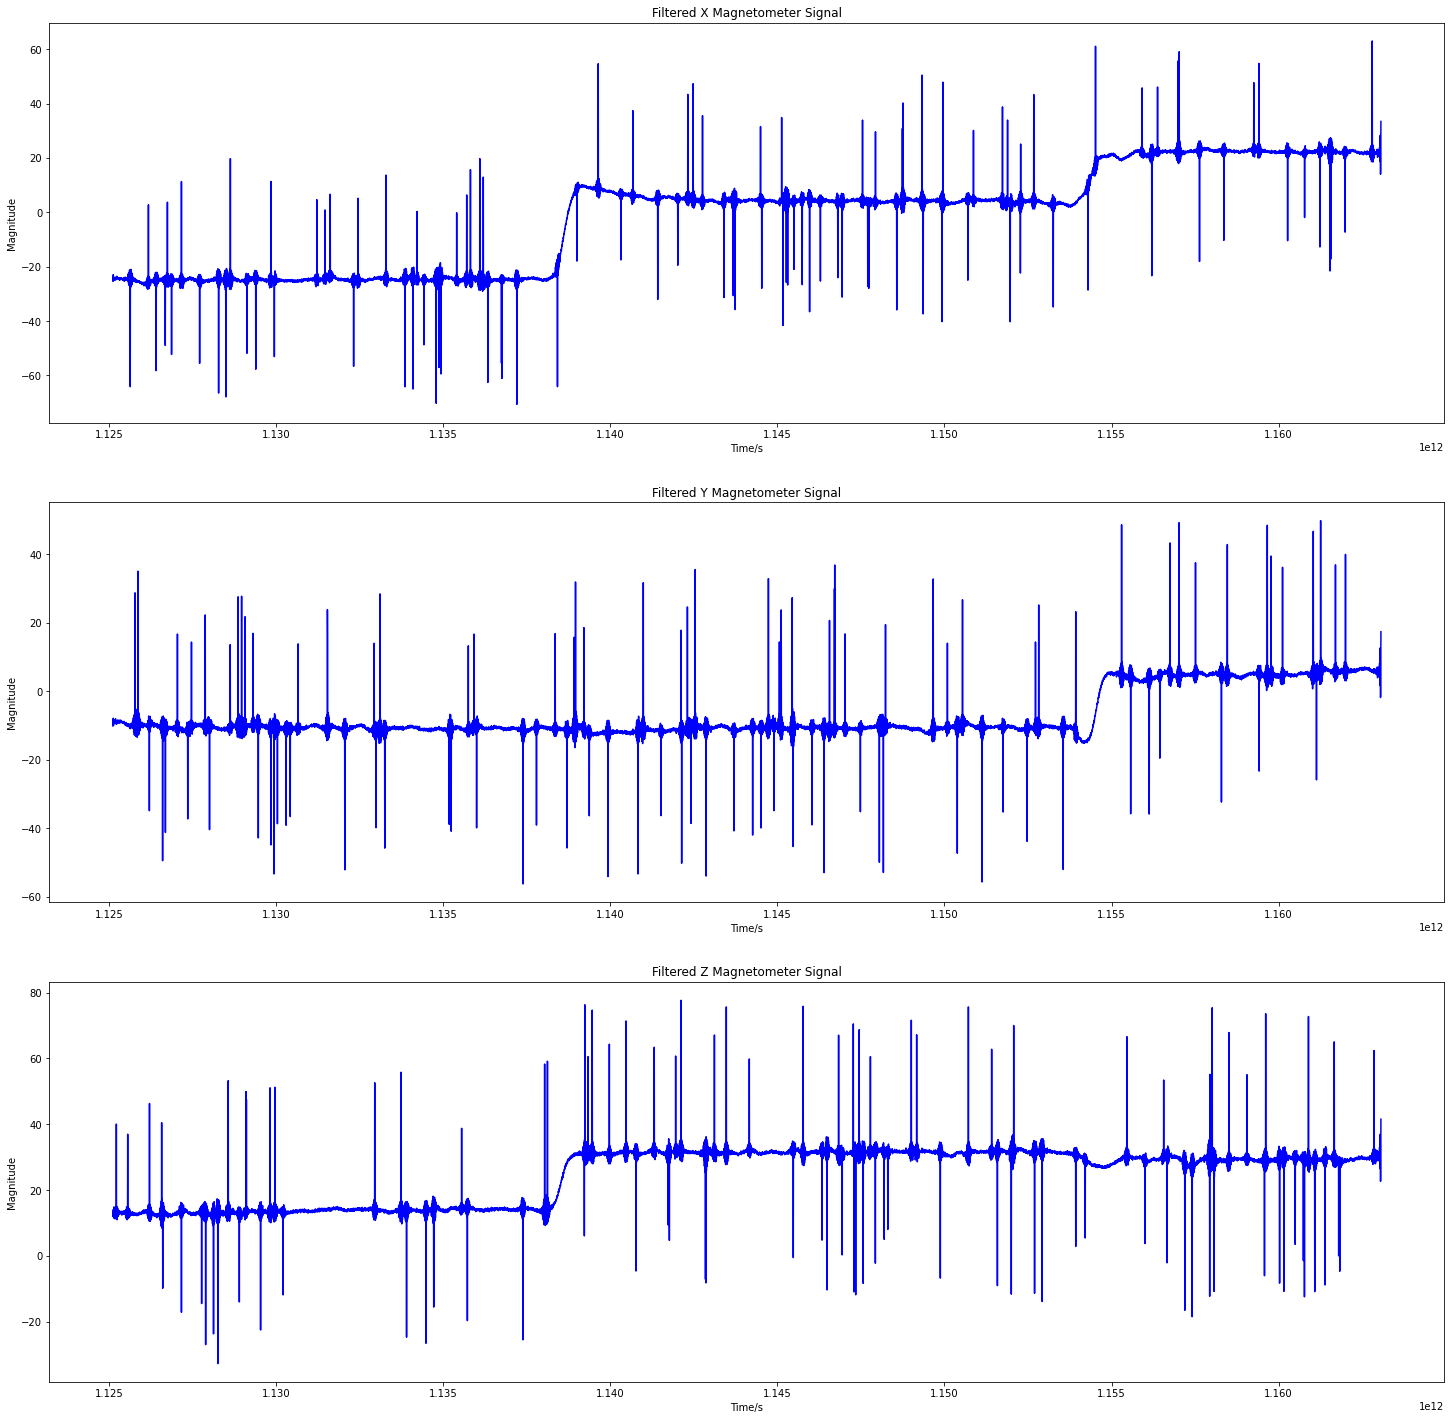

In [7]:
fig, (ax4, ax5, ax6) = plt.subplots(3, 1, figsize=(25,25))

plotter(ax4, ts_noisy_mag, noise_filter_mag[0], 'Time/s', 'Magnitude', 'Filtered X Magnetometer Signal', color='b')
plotter(ax5, ts_noisy_mag, noise_filter_mag[1], 'Time/s', 'Magnitude', 'Filtered Y Magnetometer Signal', color='b')
plotter(ax6, ts_noisy_mag, noise_filter_mag[2], 'Time/s', 'Magnitude', 'Filtered Z Magnetometer Signal', color='b')

# Question 2c

In [8]:
all_noisy_pitch = []
all_noisy_yaw = []
all_noisy_roll = []

for i in range(len(noisy_acc_x)):
    R = getRotationMatrix(
        noisy_acc_x[i], 
        noisy_acc_y[i], 
        noisy_acc_z[i], 
        noisy_mag_x[i], 
        noisy_mag_y[i], 
        noisy_mag_z[i]
    )
    (noisy_pitch, noisy_yaw, noisy_roll) = getOrientation(R)
    all_noisy_pitch.append(noisy_pitch)
    all_noisy_yaw.append(noisy_yaw)
    all_noisy_roll.append(noisy_roll)

filtered_acc_x = filter_signal(noisy_acc_x, sample_freq)
filtered_acc_y = filter_signal(noisy_acc_y, sample_freq)
filtered_acc_z = filter_signal(noisy_acc_z, sample_freq)

filtered_mag_x = filter_signal(noisy_mag_x, sample_freq)
filtered_mag_y = filter_signal(noisy_mag_y, sample_freq)
filtered_mag_z = filter_signal(noisy_mag_z, sample_freq)


all_filtered_pitch = []
all_filtered_yaw = []
all_filtered_roll = []

for i in range(len(noisy_acc_x)):
    R = getRotationMatrix(
        filtered_acc_x[i], 
        filtered_acc_y[i], 
        filtered_acc_z[i], 
        filtered_mag_x[i], 
        filtered_mag_y[i], 
        filtered_mag_z[i]
    )
    (filtered_pitch, filtered_yaw, filtered_roll) = getOrientation(R)
    all_filtered_pitch.append(filtered_pitch)
    all_filtered_yaw.append(filtered_yaw)
    all_filtered_roll.append(filtered_roll)

## Filtered Roll vs Noisy Roll

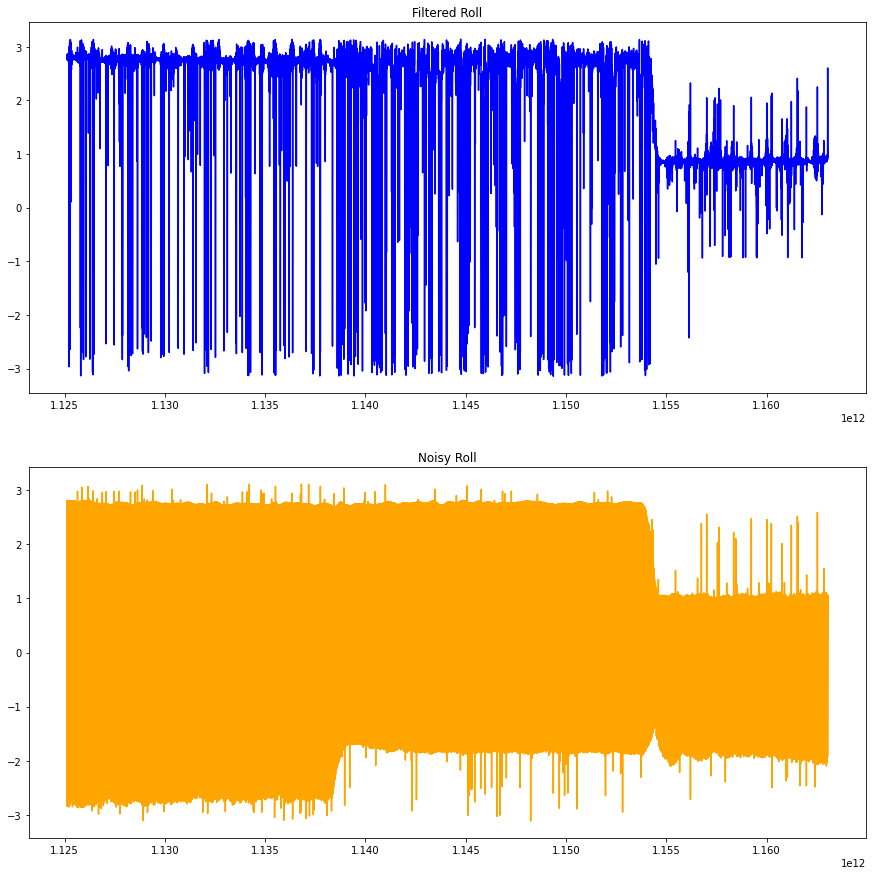

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
plotter(ax1, ts_noisy_acc, all_filtered_roll, '', '', 'Filtered Roll', 'b')
plotter(ax2, ts_noisy_acc, all_noisy_roll, '', '', 'Noisy Roll', 'orange')

## Filtered Yaw vs Noisy Yaw

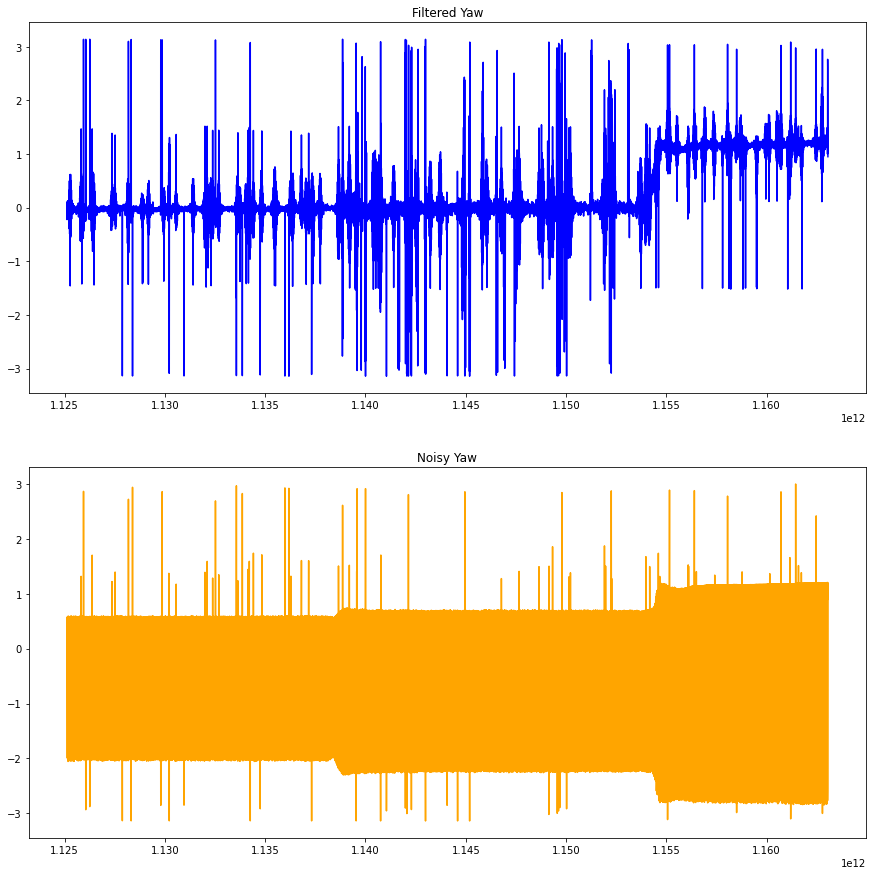

In [10]:
fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(15,15))
plotter(ax3, ts_noisy_acc, all_filtered_yaw, '', '', 'Filtered Yaw', 'b')
plotter(ax4, ts_noisy_acc, all_noisy_yaw, '', '', 'Noisy Yaw', 'orange')

## Filtered Pitch vs Noisy PItch

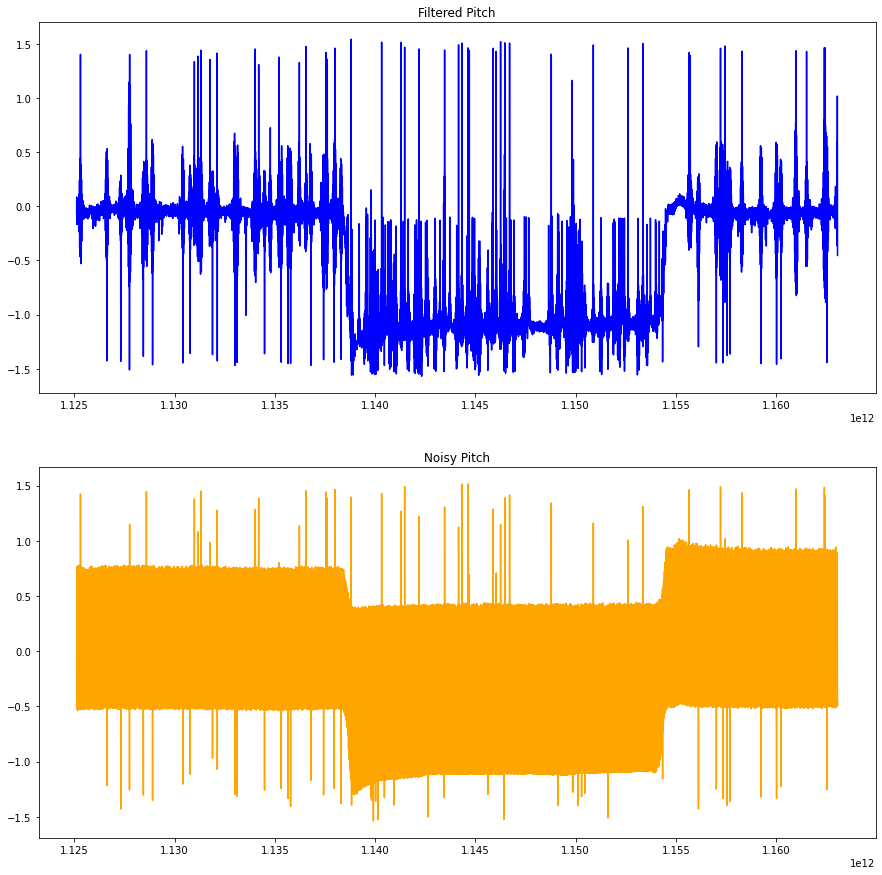

In [11]:
fig, (ax5, ax6) = plt.subplots(2, 1, figsize=(15,15))
plotter(ax5, ts_noisy_acc, all_filtered_pitch, '', '', 'Filtered Pitch', 'b')
plotter(ax6, ts_noisy_acc, all_noisy_pitch, '', '', 'Noisy Pitch', 'orange')

# Question 2d

In [30]:
def median_filter(input_signal, window_sz=3):
    result = np.zeros(len(input_signal))
    
    result[:window_sz] = np.mean(input_signal[:window_sz])
    index=window_sz
    while index<len(input_signal):
        l = index-window_sz+1
        window = input_signal[l:(index+1)]
        median_val = np.median(window)
        result[index] = median_val
        index += 1
    
    return result

median_average_filtered_acc = []
median_average_filtered_mag = []

for n in noise_filter_acc:
  median_average_filtered_acc.append(median_filter(n,64))
for n in noise_filter_mag:
  median_average_filtered_mag.append(median_filter(n,64))

all_med_filtered_pitch = []
all_med_filtered_yaw = []
all_med_filtered_roll = []

for i in range(len(median_average_filtered_acc[0])):
  R = getRotationMatrix(
    median_average_filtered_acc[0][i],
    median_average_filtered_acc[1][i],
    median_average_filtered_acc[2][i],
    median_average_filtered_mag[0][i],
    median_average_filtered_mag[1][i],
    median_average_filtered_mag[2][i]
  )
  (med_filtered_pitch, med_filtered_yaw, med_filtered_roll) = getOrientation(R)
  all_med_filtered_pitch.append(med_filtered_pitch)
  all_med_filtered_yaw.append(med_filtered_yaw)
  all_med_filtered_roll.append(med_filtered_roll)

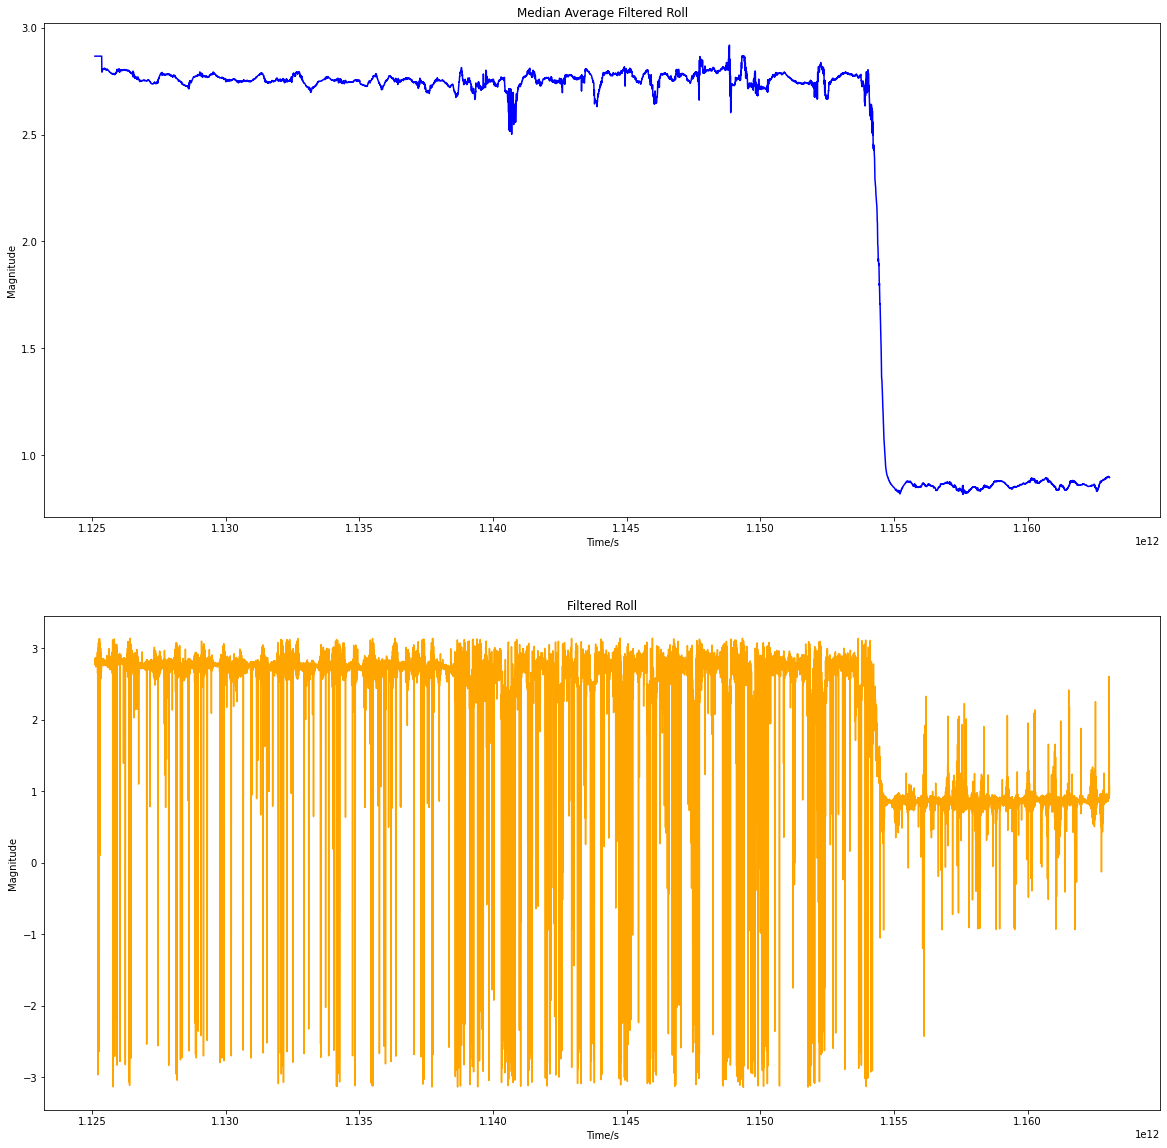

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))
plotter(ax1, ts_noisy_acc, all_med_filtered_roll, 'Time/s', 'Magnitude', 'Median Average Filtered Roll', color='b')
plotter(ax2, ts_noisy_acc, all_filtered_roll, 'Time/s', 'Magnitude', 'Filtered Roll', color='orange')

## Median Averaged Filtered Yaw vs Filtered Yaw

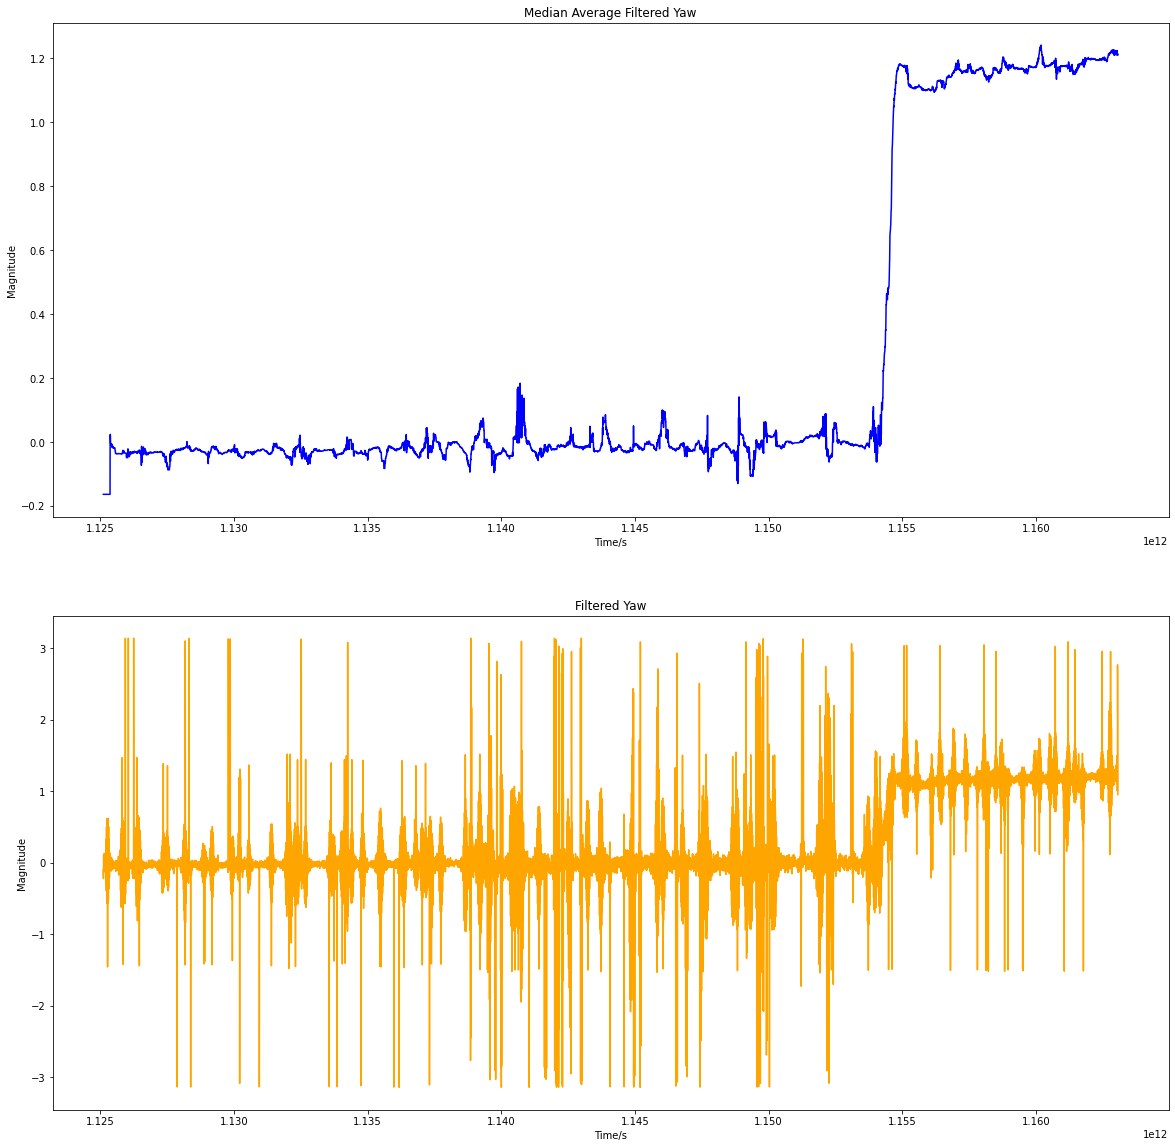

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))
plotter(ax1, ts_noisy_acc, all_med_filtered_yaw, 'Time/s', 'Magnitude', 'Median Average Filtered Yaw', color='b')
plotter(ax2, ts_noisy_acc, all_filtered_yaw, 'Time/s', 'Magnitude', 'Filtered Yaw', color='orange')

## Median Averaged Filtered Pitch vs Filtered Pitch

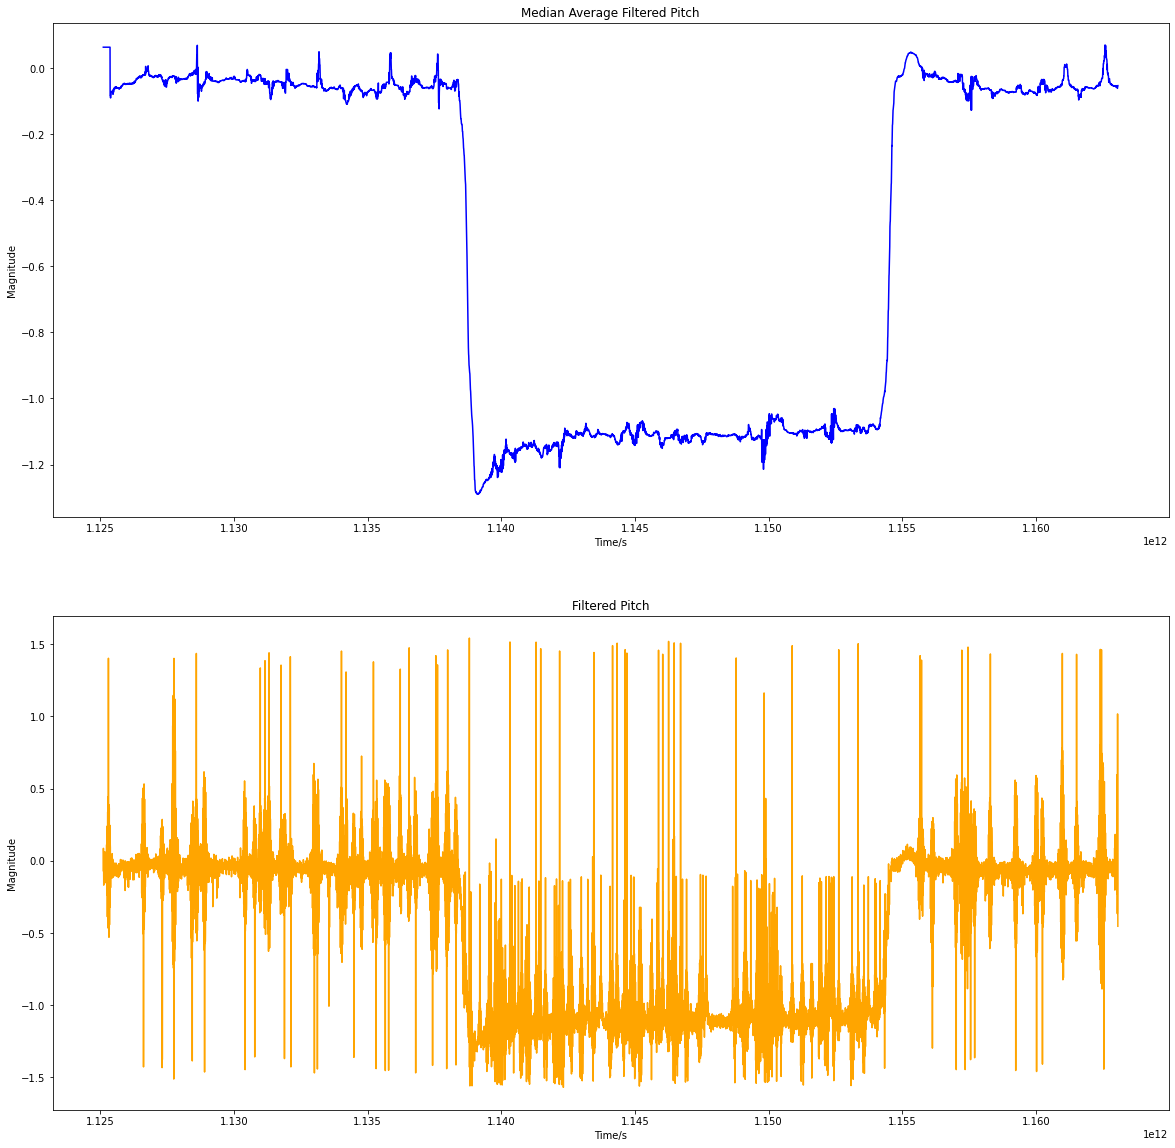

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))
plotter(ax1, ts_noisy_acc, all_med_filtered_pitch, 'Time/s', 'Magnitude', 'Median Average Filtered Pitch', color='b')
plotter(ax2, ts_noisy_acc, all_filtered_pitch, 'Time/s', 'Magnitude', 'Filtered Pitch', color='orange')